# 16. Simultaneous Equations Models

:::{important} Learning Objectives
:class: dropdown
By the end of this chapter, you should be able to:

**16.1** Understand the nature of simultaneous equations models (SEMs) and when they arise in economic applications.

**16.2** Recognize simultaneity bias in OLS estimation and understand why OLS fails in simultaneous systems.

**16.3** Apply identification conditions to determine which structural equations can be estimated.

**16.4** Estimate systems with more than two equations using 2SLS and 3SLS.

**16.5** Apply simultaneous equations methods to time series data for macroeconomic modeling.

**16.6** Extend SEM techniques to panel data for richer micro-econometric applications.
:::

Simultaneous equations models (SEMs) formalize the economic reality that many variables are determined jointly through systems of interdependent relationships rather than through unidirectional causal chains. This chapter develops the theory and practice of estimating structural equation systems, addressing the fundamental identification problem that arises when variables simultaneously determine one another and establishing conditions under which structural parameters can be consistently estimated despite this simultaneity.

The development proceeds from motivation through identification to estimation. We establish the nature of simultaneity bias and why OLS fails in systems where endogenous variables appear as regressors (Section 16.1), introduce the distinction between structural and reduced form equations that transforms simultaneous systems into estimable forms (Section 16.2), develop the rank and order conditions for identification that determine whether structural parameters are recoverable from the data (Section 16.3), present estimation methods including equation-by-equation 2SLS and system methods like three-stage least squares (3SLS) that exploit cross-equation restrictions for efficiency (Section 16.4), and extend SEM techniques to time series and panel data contexts (Section 16.5-16.6). Throughout, we implement methods using Python's linearmodels package and demonstrate applications to supply and demand systems, labor market equilibrium, and macroeconomic models with multiple equations.

In [1]:
# %pip install matplotlib numpy pandas statsmodels wooldridge linearmodels scipy -q

In [2]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import wooldridge as wool
from IPython.display import display
from linearmodels.iv import IV2SLS
from linearmodels.system import IV3SLS

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## 16.1 The Nature of Simultaneous Equations Models

A **simultaneous equations model** consists of multiple equations where some variables appear as dependent variables in one equation and as explanatory variables in another.

### General SEM Structure

Consider a two-equation system:

$$ y_1 = \beta_{10} + \beta_{12} y_2 + \beta_{11} z_1 + u_1 $$

$$ y_2 = \beta_{20} + \beta_{21} y_1 + \beta_{22} z_2 + u_2 $$

where:
- $y_1, y_2$ = **endogenous variables** (determined within the system)
- $z_1, z_2$ = **exogenous variables** (determined outside the system)
- $u_1, u_2$ = **structural errors**

Key features:
1. $y_2$ appears on the RHS of equation 1
2. $y_1$ appears on the RHS of equation 2
3. This creates **simultaneity** (mutual dependence)

### Structural vs. Reduced Form

**Structural equations** are the behavioral equations of interest:
- Represent economic theory (e.g., supply and demand functions)
- Parameters have direct economic interpretation
- Cannot be estimated by OLS if endogenous variables appear on RHS

**Reduced form equations** express each endogenous variable as a function of ALL exogenous variables only:

$$ y_1 = \pi_{10} + \pi_{11} z_1 + \pi_{12} z_2 + v_1 $$

$$ y_2 = \pi_{20} + \pi_{21} z_1 + \pi_{22} z_2 + v_2 $$

- Can be estimated by OLS (all RHS variables are exogenous)
- Don't have direct economic interpretation
- Used to construct instruments for structural estimation

### Classic Example: Supply and Demand

**Structural equations**:

$$ \text{Quantity}_D = \alpha_0 - \alpha_1 \text{Price} + \alpha_2 \text{Income} + u_D \quad \text{(Demand)} $$

$$ \text{Quantity}_S = \beta_0 + \beta_1 \text{Price} + \beta_2 \text{Weather} + u_S \quad \text{(Supply)} $$

**Equilibrium condition**: $\text{Quantity}_D = \text{Quantity}_S = Q^*$

We observe equilibrium $(Q^*, P^*)$ pairs, but cannot run OLS on either equation because Price is endogenous (determined by the intersection of supply and demand).

**Solution**: Use instrumental variables
- For demand: Use supply shifters (Weather) as instruments for Price
- For supply: Use demand shifters (Income) as instruments for Price

## 16.2 Simultaneity Bias in OLS

When we apply OLS to a structural equation in a simultaneous system, we get **biased and inconsistent** estimates. The bias doesn't disappear even with large samples!

### Why OLS Fails

Consider the demand equation:

$$ Q = \alpha_0 - \alpha_1 P + \alpha_2 I + u $$

where $Q$ = quantity, $P$ = price, $I$ = income.

**Problem**: $P$ is determined simultaneously with $Q$ through market equilibrium, so:

$$ E(u | P) \neq 0 \implies \text{Cov}(P, u) \neq 0 $$

This violates the fundamental OLS assumption, leading to:

$$ \text{plim} \, \hat{\alpha}_1^{OLS} \neq \alpha_1 $$

The OLS estimator is **inconsistent**.

### Direction of Bias

The direction of simultaneity bias depends on:
1. Signs of structural parameters
2. Relative variances of supply and demand shocks
3. Whether supply or demand is steeper

**General result**: OLS estimates are a **mix** of supply and demand parameters, not pure demand or supply parameters.

### Visualizing Simultaneity Bias

In [3]:
# Simulate supply and demand with simultaneity
np.random.seed(42)
n = 200

# Exogenous variables
income = np.random.normal(50, 10, n)  # Demand shifter
weather = np.random.normal(0, 5, n)  # Supply shifter

# Structural errors
u_demand = np.random.normal(0, 3, n)
u_supply = np.random.normal(0, 3, n)

# True structural parameters
alpha_0, alpha_1, alpha_2 = 100, 2, 0.5  # Demand: Q = 100 - 2P + 0.5I + u_D
beta_0, beta_1, beta_2 = 50, 1.5, 0.3  # Supply: Q = 50 + 1.5P + 0.3W + u_S

# Solve for equilibrium price and quantity
# Q_D = Q_S -> alpha_0 - alpha_1*P + alpha_2*I + u_D = beta_0 + beta_1*P + beta_2*W + u_S
# P = (alpha_0 - beta_0 + alpha_2*I - beta_2*W + u_D - u_S) / (alpha_1 + beta_1)

price_equilibrium = (
    alpha_0 - beta_0 + alpha_2 * income - beta_2 * weather + u_demand - u_supply
) / (alpha_1 + beta_1)
quantity_equilibrium = (
    alpha_0 - alpha_1 * price_equilibrium + alpha_2 * income + u_demand
)

# Create DataFrame
sim_data = pd.DataFrame(
    {
        "quantity": quantity_equilibrium,
        "price": price_equilibrium,
        "income": income,
        "weather": weather,
    },
)

print("SIMULATED SUPPLY AND DEMAND DATA")
print("=" * 70)
print("\nTrue Structural Parameters:")
print(f"Demand:  Q = {alpha_0} - {alpha_1}*P + {alpha_2}*I + u_D")
print(f"Supply:  Q = {beta_0} + {beta_1}*P + {beta_2}*W + u_S")
print("\nObserved equilibrium data (Q*, P*) where supply = demand")

display(sim_data.describe().round(2))

SIMULATED SUPPLY AND DEMAND DATA

True Structural Parameters:
Demand:  Q = 100 - 2*P + 0.5*I + u_D
Supply:  Q = 50 + 1.5*P + 0.3*W + u_S

Observed equilibrium data (Q*, P*) where supply = demand


,quantity,price,income,weather
count,200.00,200.00,200.00,200.00
mean,82.03,21.25,49.59,0.43
std,3.10,1.63,9.31,4.94
min,74.33,17.23,23.80,-16.21
25%,79.87,20.02,42.95,-3.03
50%,81.99,21.15,49.96,0.39
75%,83.89,22.45,55.01,3.44
max,90.04,26.11,77.20,19.26


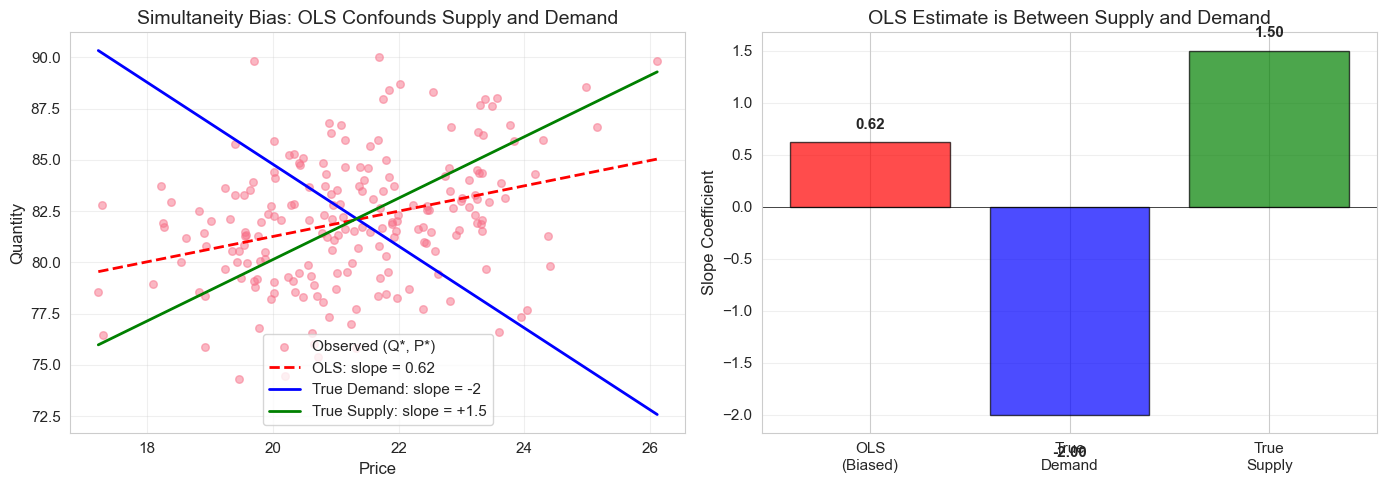


SIMULTANEITY BIAS DEMONSTRATION:
OLS slope:        0.6188
True demand slope: -2.0000
True supply slope:  1.5000

OLS is BIASED: It's between demand and supply, not equal to either!
OLS traces out the locus of equilibrium points, not a structural curve


In [4]:
# Visualize the simultaneity problem
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Scatter of observed equilibrium points
axes[0].scatter(
    sim_data["price"], sim_data["quantity"], alpha=0.5, s=30, label="Observed (Q*, P*)"
)

# OLS regression line (wrong!)
ols_wrong = smf.ols(formula="quantity ~ price", data=sim_data).fit()
p_range = np.linspace(sim_data["price"].min(), sim_data["price"].max(), 100)
axes[0].plot(
    p_range,
    ols_wrong.params["Intercept"] + ols_wrong.params["price"] * p_range,
    "r--",
    linewidth=2,
    label=f"OLS: slope = {ols_wrong.params['price']:.2f}",
)

# True demand curve (for mean income)
mean_income = income.mean()
axes[0].plot(
    p_range,
    alpha_0 + alpha_2 * mean_income - alpha_1 * p_range,
    "b-",
    linewidth=2,
    label=f"True Demand: slope = -{alpha_1}",
)

# True supply curve (for mean weather)
mean_weather = weather.mean()
axes[0].plot(
    p_range,
    beta_0 + beta_2 * mean_weather + beta_1 * p_range,
    "g-",
    linewidth=2,
    label=f"True Supply: slope = +{beta_1}",
)

axes[0].set_xlabel("Price")
axes[0].set_ylabel("Quantity")
axes[0].set_title("Simultaneity Bias: OLS Confounds Supply and Demand")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel B: Comparison of slopes
methods = ["OLS\n(Biased)", "True\nDemand", "True\nSupply"]
slopes = [ols_wrong.params["price"], -alpha_1, beta_1]
colors = ["red", "blue", "green"]

bars = axes[1].bar(methods, slopes, color=colors, alpha=0.7, edgecolor="black")
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=0.5)
axes[1].set_ylabel("Slope Coefficient")
axes[1].set_title("OLS Estimate is Between Supply and Demand")
axes[1].grid(True, alpha=0.3, axis="y")

# Add value labels on bars
for bar, slope in zip(bars, slopes, strict=False):
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.1 if height > 0 else height - 0.3,
        f"{slope:.2f}",
        ha="center",
        va="bottom" if height > 0 else "top",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

print("\nSIMULTANEITY BIAS DEMONSTRATION:")
print("=" * 70)
print(f"OLS slope:        {ols_wrong.params['price']:.4f}")
print(f"True demand slope: {-alpha_1:.4f}")
print(f"True supply slope:  {beta_1:.4f}")
print("\nOLS is BIASED: It's between demand and supply, not equal to either!")
print("OLS traces out the locus of equilibrium points, not a structural curve")

## 16.3 Identifying and Estimating a Structural Equation

Before we can estimate a structural equation, we must determine if it is **identified**. Identification asks: "Can we uniquely recover the structural parameters from the reduced form?"

### Identification Concepts

**Three possible states**:

1. **Underidentified**: Cannot recover structural parameters (not enough instruments)
2. **Just identified**: Can uniquely recover parameters (exactly identified)
3. **Overidentified**: More than enough instruments (can test overidentifying restrictions)

### Order Condition for Identification

For equation $i$ in a system:

$$ \text{# excluded exogenous variables} \geq \text{# included endogenous variables} - 1 $$

This is a **necessary but not sufficient** condition.

**Rule of thumb**: Each endogenous variable on the RHS needs at least one **excluded exogenous variable** (an exogenous variable that appears in other equations but not in this one) to serve as an instrument.

### Rank Condition (Necessary and Sufficient)

The rank condition is more technical but guarantees identification. For equation $i$:

The rank of the matrix of coefficients on variables **excluded from equation $i$** must equal the number of endogenous variables in the system minus 1.

**In practice**: 
- Use order condition as a quick check
- Order satisfied + economic theory -> likely identified
- Formal rank condition checked by software

### Example: Labor Supply and Wage Determination

Consider a woman's labor supply decision:

**Equation 1 (Labor Supply)**:
$$ \text{hours} = \beta_{10} + \beta_{12} \log(\text{wage}) + \beta_{11} \text{educ} + \beta_{12} \text{age} + \beta_{13} \text{kidslt6} + \beta_{14} \text{nwifeinc} + u_1 $$

**Equation 2 (Wage Equation)**:
$$ \log(\text{wage}) = \beta_{20} + \beta_{21} \text{hours} + \beta_{22} \text{educ} + \beta_{23} \text{exper} + \beta_{24} \text{exper}^2 + u_2 $$

**Endogenous variables**: hours, log(wage)
**Exogenous variables**: educ, age, kidslt6, nwifeinc, exper, exper^2

**Identification check for Equation 1**:
- Endogenous on RHS: log(wage) -> need 1 excluded exogenous variable
- Excluded exogenous: exper, exper^2 -> have 2 instruments
- **Overidentified** YES

**Identification check for Equation 2**:
- Endogenous on RHS: hours -> need 1 excluded exogenous variable  
- Excluded exogenous: age, kidslt6, nwifeinc -> have 3 instruments
- **Overidentified** YES

## 16.4 Systems with More Than Two Equations

When we have multiple equations, we can estimate them:
1. **Equation-by-equation** using 2SLS
2. **Jointly** using 3SLS (three-stage least squares)

### Two-Stage Least Squares (2SLS) for Each Equation

**Advantages**:
- Simple to implement (apply 2SLS to each equation separately)
- Consistent estimators
- Robust: if one equation is misspecified, others are unaffected

**Disadvantages**:
- Ignores cross-equation error correlations
- Less efficient than 3SLS when errors are correlated

### Three-Stage Least Squares (3SLS)

**3SLS** is a **system estimator** that accounts for correlation between errors across equations.

**Three stages**:

1. **First stage**: Run reduced form regressions (like 2SLS first stage)
2. **Second stage**: Estimate each equation by 2SLS, save residuals
3. **Third stage**: Use residuals to estimate error covariance matrix, then apply **generalized least squares (GLS)** to the entire system

**Advantages**:
- More efficient than 2SLS when errors are correlated across equations
- System estimation can improve precision

**Disadvantages**:
- If one equation is misspecified, all estimates are affected
- More complex to implement
- Requires correct specification of entire system

### When to Use 3SLS vs 2SLS

Use **3SLS** when:
- You believe errors are correlated across equations
- All equations are correctly specified
- Want maximum efficiency

Use **2SLS** when:
- Uncertain about specification of some equations
- Want robustness to misspecification
- Simpler interpretation and diagnostics

### Example 16.5: Labor Supply and Wage System

We'll estimate the labor supply and wage system using both 2SLS and 3SLS.

In [5]:
# Load married women's labor force participation data
mroz = wool.data("mroz")

# Restrict to working women (non-missing wages)
mroz_working = mroz.dropna(subset=["lwage"])

print("SIMULTANEOUS EQUATIONS: Labor Supply and Wages")
print("=" * 70)
print("\nSample: Married women with observed wages")
print(f"Observations: {len(mroz_working)}")

print("\nSTRUCTURAL EQUATIONS:")
print("\n1. Labor Supply Equation:")
print(
    "   hours = beta_1_0 + beta_1_2*log(wage) + beta_1_1*educ + beta_1_2*age + beta_1_3*kidslt6 + beta_1_4*nwifeinc + u_1"
)
print("   Endogenous: log(wage)")
print("   Instruments: exper, exper^2")

print("\n2. Wage Equation:")
print("   log(wage) = beta_2_0 + beta_2_1*hours + beta_2_2*educ + beta_2_3*exper + beta_2_4*exper^2 + u_2")
print("   Endogenous: hours")
print("   Instruments: age, kidslt6, nwifeinc")

print("\nKEY QUESTION: Are hours and wages simultaneously determined?")
print("- Labor supply theory: Higher wages -> More hours worked (substitution effect)")
print("- Wage determination: More hours -> Lower hourly wage? (fatigue, bargaining)")

# Summary statistics
key_vars = ["hours", "lwage", "educ", "age", "kidslt6", "nwifeinc", "exper"]
display(mroz_working[key_vars].describe().round(2))

SIMULTANEOUS EQUATIONS: Labor Supply and Wages

Sample: Married women with observed wages
Observations: 428

STRUCTURAL EQUATIONS:

1. Labor Supply Equation:
   hours = beta_1_0 + beta_1_2*log(wage) + beta_1_1*educ + beta_1_2*age + beta_1_3*kidslt6 + beta_1_4*nwifeinc + u_1
   Endogenous: log(wage)
   Instruments: exper, exper^2

2. Wage Equation:
   log(wage) = beta_2_0 + beta_2_1*hours + beta_2_2*educ + beta_2_3*exper + beta_2_4*exper^2 + u_2
   Endogenous: hours
   Instruments: age, kidslt6, nwifeinc

KEY QUESTION: Are hours and wages simultaneously determined?
- Labor supply theory: Higher wages -> More hours worked (substitution effect)
- Wage determination: More hours -> Lower hourly wage? (fatigue, bargaining)


,hours,lwage,educ,age,kidslt6,nwifeinc,exper
count,428.00,428.00,428.00,428.00,428.00,428.00,428.00
mean,1302.93,1.19,12.66,41.97,0.14,18.94,13.04
std,776.27,0.72,2.29,7.72,0.39,10.59,8.06
min,12.00,-2.05,5.00,30.00,0.00,-0.03,0.00
25%,609.50,0.82,12.00,35.00,0.00,12.37,7.00
50%,1365.50,1.25,12.00,42.00,0.00,17.08,12.00
75%,1910.50,1.60,14.00,47.25,0.00,23.51,18.00
max,4950.00,3.22,17.00,60.00,2.00,91.00,38.00


In [6]:
# EQUATION-BY-EQUATION 2SLS ESTIMATION
print("\n2SLS ESTIMATION (Equation-by-Equation)")
print("=" * 70)

# Equation 1: Labor Supply (hours depends on wage)
print("\nEQUATION 1: Labor Supply")
print("-" * 70)
print("Dependent variable: hours")
print("Endogenous regressor: log(wage)")
print("Instruments: exper, exper^2")

labor_supply_2sls = IV2SLS.from_formula(
    formula="hours ~ 1 + educ + age + kidslt6 + nwifeinc + "
    "[np.log(wage) ~ exper + I(exper**2)]",
    data=mroz_working,
).fit(cov_type="unadjusted", debiased=True)

table_supply = pd.DataFrame(
    {
        "Coefficient": labor_supply_2sls.params,
        "Std. Error": labor_supply_2sls.std_errors,
        "t-statistic": labor_supply_2sls.tstats,
        "p-value": labor_supply_2sls.pvalues,
    },
)
display(table_supply.round(4))

print(f"\nR-squared: {labor_supply_2sls.rsquared:.4f}")
print("First-stage F-stat: Check that instruments are relevant")


2SLS ESTIMATION (Equation-by-Equation)

EQUATION 1: Labor Supply
----------------------------------------------------------------------
Dependent variable: hours
Endogenous regressor: log(wage)
Instruments: exper, exper^2


,Coefficient,Std. Error,t-statistic,p-value
Intercept,2225.6618,574.5641,3.8737,0.0001
educ,-183.7513,59.0998,-3.1092,0.0020
age,-7.8061,9.3780,-0.8324,0.4057
kidslt6,-198.1543,182.9291,-1.0832,0.2793
nwifeinc,-10.1696,6.6147,-1.5374,0.1249
np.log(wage),1639.5556,470.5757,3.4841,0.0005



R-squared: -2.0076
First-stage F-stat: Check that instruments are relevant


In [7]:
# Equation 2: Wage Equation (wage depends on hours)
print("\nEQUATION 2: Wage Equation")
print("-" * 70)
print("Dependent variable: log(wage)")
print("Endogenous regressor: hours")
print("Instruments: age, kidslt6, nwifeinc")

wage_eq_2sls = IV2SLS.from_formula(
    formula="np.log(wage) ~ 1 + educ + exper + I(exper**2) + "
    "[hours ~ age + kidslt6 + nwifeinc]",
    data=mroz_working,
).fit(cov_type="unadjusted", debiased=True)

table_wage = pd.DataFrame(
    {
        "Coefficient": wage_eq_2sls.params,
        "Std. Error": wage_eq_2sls.std_errors,
        "t-statistic": wage_eq_2sls.tstats,
        "p-value": wage_eq_2sls.pvalues,
    },
)
display(table_wage.round(4))

print(f"\nR-squared: {wage_eq_2sls.rsquared:.4f}")


EQUATION 2: Wage Equation
----------------------------------------------------------------------
Dependent variable: log(wage)
Endogenous regressor: hours
Instruments: age, kidslt6, nwifeinc


,Coefficient,Std. Error,t-statistic,p-value
Intercept,-0.6557,0.3378,-1.9412,0.0529
educ,0.1103,0.0155,7.1069,0.0000
exper,0.0346,0.0195,1.7742,0.0767
I(exper ** 2),-0.0007,0.0005,-1.5543,0.1209
hours,0.0001,0.0003,0.4945,0.6212



R-squared: 0.1257


In [8]:
# Check for cross-equation error correlation
print("\nCHECKING CROSS-EQUATION ERROR CORRELATION")
print("=" * 70)
print("If residuals are correlated, 3SLS will be more efficient than 2SLS")

# Get residuals from both equations
u1_hat = labor_supply_2sls.resids.values
u2_hat = wage_eq_2sls.resids.values

# Calculate correlation
cor_u1u2 = np.corrcoef(u1_hat, u2_hat)[0, 1]

print(f"\nCorrelation between residuals: {cor_u1u2:.4f}")

if abs(cor_u1u2) > 0.1:
    print(f"YES Substantial correlation (|{cor_u1u2:.4f}| > 0.1)")
    print("  -> 3SLS will be more efficient than 2SLS")
    print("  -> Errors across equations are related")
else:
    print(f"NO Low correlation (|{cor_u1u2:.4f}| <= 0.1)")
    print("  -> Little efficiency gain from 3SLS")
    print("  -> 2SLS and 3SLS will give similar results")


CHECKING CROSS-EQUATION ERROR CORRELATION
If residuals are correlated, 3SLS will be more efficient than 2SLS

Correlation between residuals: -0.9038
YES Substantial correlation (|-0.9038| > 0.1)
  -> 3SLS will be more efficient than 2SLS
  -> Errors across equations are related


In [9]:
# Interpretation of 2SLS results
print("\nINTERPRETATION OF 2SLS RESULTS")
print("=" * 70)

# Labor supply equation
wage_effect = labor_supply_2sls.params["np.log(wage)"]
wage_se = labor_supply_2sls.std_errors["np.log(wage)"]

print("\n1. LABOR SUPPLY EQUATION:")
print(f"   Effect of wage on hours: {wage_effect:.2f}")
if wage_effect > 0:
    print(f"   A 1% increase in wage -> {wage_effect:.2f} more hours worked per year")
    print("   YES Positive substitution effect (higher wage -> more labor supply)")
else:
    print(f"   A 1% increase in wage -> {abs(wage_effect):.2f} fewer hours worked")
    print("   YES Negative income effect dominates (higher wage -> less need to work)")

print(f"\n   Standard error: {wage_se:.4f}")
if abs(wage_effect / wage_se) > 1.96:
    print(f"   YES Statistically significant (t = {wage_effect / wage_se:.2f})")
else:
    print(f"   NO Not statistically significant (t = {wage_effect / wage_se:.2f})")

# Wage equation
hours_effect = wage_eq_2sls.params["hours"]
hours_se = wage_eq_2sls.std_errors["hours"]

print("\n2. WAGE EQUATION:")
print(f"   Effect of hours on log(wage): {hours_effect:.6f}")
if hours_effect > 0:
    print(f"   Each additional hour worked -> {100 * hours_effect:.4f}% higher wage")
    print("   Interpretation: Positive correlation (more productive workers work more)")
else:
    print(f"   Each additional hour worked -> {100 * abs(hours_effect):.4f}% lower wage")
    print("   Interpretation: Fatigue effect or part-time premium")

print(f"\n   Standard error: {hours_se:.6f}")
if abs(hours_effect / hours_se) > 1.96:
    print(f"   YES Statistically significant (t = {hours_effect / hours_se:.2f})")
else:
    print(f"   NO Not statistically significant (t = {hours_effect / hours_se:.2f})")


INTERPRETATION OF 2SLS RESULTS

1. LABOR SUPPLY EQUATION:
   Effect of wage on hours: 1639.56
   A 1% increase in wage -> 1639.56 more hours worked per year
   YES Positive substitution effect (higher wage -> more labor supply)

   Standard error: 470.5757
   YES Statistically significant (t = 3.48)

2. WAGE EQUATION:
   Effect of hours on log(wage): 0.000126
   Each additional hour worked -> 0.0126% higher wage
   Interpretation: Positive correlation (more productive workers work more)

   Standard error: 0.000255
   NO Not statistically significant (t = 0.49)


In [10]:
# THREE-STAGE LEAST SQUARES (3SLS)
print("\n\n3SLS ESTIMATION (System Estimation)")
print("=" * 70)
print("Estimates entire system jointly, accounting for cross-equation correlations")

# Define system of equations
system_formula = {
    "labor_supply": "hours ~ 1 + educ + age + kidslt6 + nwifeinc + "
    "[np.log(wage) ~ exper + I(exper**2)]",
    "wage_eq": "np.log(wage) ~ 1 + educ + exper + I(exper**2) + "
    "[hours ~ age + kidslt6 + nwifeinc]",
}

# Estimate system
system_3sls = IV3SLS.from_formula(system_formula, data=mroz_working)
results_3sls = system_3sls.fit(cov_type="unadjusted", debiased=True)

print("\n3SLS SYSTEM RESULTS")
print(results_3sls)



3SLS ESTIMATION (System Estimation)
Estimates entire system jointly, accounting for cross-equation correlations

3SLS SYSTEM RESULTS
                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                  -2.3957
No. Equations.:                     2   McElroy's R-squared:                 0.7846
No. Observations:                 428   Judge's (OLS) R-squared:            -2.3957
Date:                Mon, Oct 20 2025   Berndt's R-squared:                  0.5181
Time:                        20:08:34   Dhrymes's R-squared:                -2.3957
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
               Equation: labor_supply, Dependent Variable: hours                
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------

In [11]:
# Compare 2SLS and 3SLS estimates
print("\n\nCOMPARISON: 2SLS vs 3SLS")
print("=" * 70)

print("\nLabor Supply Equation (hours):")
print("-" * 70)

comparison_supply = pd.DataFrame(
    {
        "2SLS": labor_supply_2sls.params,
        "2SLS SE": labor_supply_2sls.std_errors,
        "3SLS": results_3sls.params.filter(like="labor_supply"),
        "3SLS SE": results_3sls.std_errors.filter(like="labor_supply"),
    },
)

# Clean up index names for 3SLS
comparison_supply.index = [
    idx.replace("labor_supply_", "") for idx in comparison_supply.index
]
display(comparison_supply.round(4))

print("\nWage Equation (log(wage)):")
print("-" * 70)

comparison_wage = pd.DataFrame(
    {
        "2SLS": wage_eq_2sls.params,
        "2SLS SE": wage_eq_2sls.std_errors,
        "3SLS": results_3sls.params.filter(like="wage_eq"),
        "3SLS SE": results_3sls.std_errors.filter(like="wage_eq"),
    },
)

# Clean up index names for 3SLS
comparison_wage.index = [idx.replace("wage_eq_", "") for idx in comparison_wage.index]
display(comparison_wage.round(4))

print("\nKEY INSIGHTS:")
print("1. Coefficients: 2SLS and 3SLS estimates are similar (as expected)")
print("2. Standard Errors: 3SLS should have smaller SEs if errors are correlated")
print("3. Both methods account for simultaneity (unlike OLS which is biased)")
print("\nWHICH TO USE?")
print("- 3SLS: More efficient if system is correctly specified")
print("- 2SLS: More robust to misspecification of individual equations")
print("- In practice: Report both and compare for robustness")



COMPARISON: 2SLS vs 3SLS

Labor Supply Equation (hours):
----------------------------------------------------------------------


,2SLS,2SLS SE,3SLS,3SLS SE
Intercept,2225.6618,574.5641,NaN,NaN
age,-7.8061,9.3780,NaN,NaN
educ,-183.7513,59.0998,NaN,NaN
kidslt6,-198.1543,182.9291,NaN,NaN
Intercept,NaN,NaN,2305.8575,511.5407
age,NaN,NaN,-9.5150,7.9609
educ,NaN,NaN,-212.8195,53.7270
kidslt6,NaN,NaN,-192.3591,150.9175
np.log(wage),NaN,NaN,1781.9334,439.8842
nwifeinc,NaN,NaN,-0.1770,3.5836



Wage Equation (log(wage)):
----------------------------------------------------------------------


,2SLS,2SLS SE,3SLS,3SLS SE
I(exper ** 2),-0.0007,0.0005,NaN,NaN
Intercept,-0.6557,0.3378,NaN,NaN
educ,0.1103,0.0155,NaN,NaN
exper,0.0346,0.0195,NaN,NaN
hours,0.0001,0.0003,NaN,NaN
I(exper ** 2),NaN,NaN,-0.0003,0.0003
Intercept,NaN,NaN,-0.6939,0.3360
educ,NaN,NaN,0.1127,0.0154
exper,NaN,NaN,0.0214,0.0154
hours,NaN,NaN,0.0002,0.0002



KEY INSIGHTS:
1. Coefficients: 2SLS and 3SLS estimates are similar (as expected)
2. Standard Errors: 3SLS should have smaller SEs if errors are correlated
3. Both methods account for simultaneity (unlike OLS which is biased)

WHICH TO USE?
- 3SLS: More efficient if system is correctly specified
- 2SLS: More robust to misspecification of individual equations
- In practice: Report both and compare for robustness


## 16.5 Simultaneous Equations Models with Time Series

SEMs are particularly important for **macroeconomic models** where variables like GDP, consumption, investment, and interest rates are jointly determined.

### Time Series Considerations

When applying SEMs to time series data:

1. **Stationarity**: Ensure variables are stationary (or cointegrated)
2. **Serial correlation**: Use robust standard errors or model dynamics explicitly
3. **Lagged endogenous variables**: Can serve as instruments (if predetermined)
4. **Identification**: Same rules apply, but more instruments available (lags)

### Classic Macro SEM: IS-LM Model

A simplified Keynesian macro model:

**IS Equation (Investment-Savings)**:
$$ Y_t = \alpha_0 + \alpha_1 r_t + \alpha_2 G_t + u_t $$

**LM Equation (Liquidity-Money)**:
$$ r_t = \beta_0 + \beta_1 Y_t + \beta_2 M_t + v_t $$

where:
- $Y_t$ = GDP (endogenous)
- $r_t$ = interest rate (endogenous)
- $G_t$ = government spending (exogenous)
- $M_t$ = money supply (exogenous)

**Identification**:
- IS equation: Excluded exogenous = $M_t$ -> identified
- LM equation: Excluded exogenous = $G_t$ -> identified

### Dynamic SEMs

In practice, macro models include **dynamics** (lags):

$$ Y_t = \alpha_0 + \alpha_1 r_t + \alpha_2 Y_{t-1} + \alpha_3 G_t + u_t $$

Lagged endogenous variables ($Y_{t-1}$) are **predetermined** and can serve as instruments (assuming no serial correlation in errors).

In [12]:
# Conceptual example of macro SEM
print("TIME SERIES SEM: Macroeconomic Model")
print("=" * 70)

print("\nIS-LM MODEL (Conceptual)")
print("\nIS Equation (Goods Market Equilibrium):")
print("  Y = alpha_0 + alpha_1*r + alpha_2*G + u")
print("  Output (Y) depends negatively on interest rate (r)")
print("  Government spending (G) is exogenous policy variable")

print("\nLM Equation (Money Market Equilibrium):")
print("  r = beta_0 + beta_1*Y + beta_2*M + v")
print("  Interest rate (r) depends positively on output (Y)")
print("  Money supply (M) is exogenous policy variable")

print("\nIDENTIFICATION:")
print("YES IS equation: Use M (excluded from IS) as instrument for r")
print("YES LM equation: Use G (excluded from LM) as instrument for Y")

print("\nESTIMATION:")
print("- Apply 2SLS to each equation using appropriate instruments")
print("- Or use 3SLS for system estimation")
print("- With time series: Check stationarity, use robust SEs")

print("\nEXTENSIONS:")
print("- Add dynamics: Y_{t-1}, r_{t-1} as regressors")
print("- Use lags as instruments (if predetermined)")
print("- Model expectations: Forward-looking behavior")

TIME SERIES SEM: Macroeconomic Model

IS-LM MODEL (Conceptual)

IS Equation (Goods Market Equilibrium):
  Y = alpha_0 + alpha_1*r + alpha_2*G + u
  Output (Y) depends negatively on interest rate (r)
  Government spending (G) is exogenous policy variable

LM Equation (Money Market Equilibrium):
  r = beta_0 + beta_1*Y + beta_2*M + v
  Interest rate (r) depends positively on output (Y)
  Money supply (M) is exogenous policy variable

IDENTIFICATION:
YES IS equation: Use M (excluded from IS) as instrument for r
YES LM equation: Use G (excluded from LM) as instrument for Y

ESTIMATION:
- Apply 2SLS to each equation using appropriate instruments
- Or use 3SLS for system estimation
- With time series: Check stationarity, use robust SEs

EXTENSIONS:
- Add dynamics: Y_{t-1}, r_{t-1} as regressors
- Use lags as instruments (if predetermined)
- Model expectations: Forward-looking behavior


## 16.6 Simultaneous Equations Models with Panel Data

Panel data provides **additional instruments** through the time dimension, making identification easier. We can combine:
- Fixed effects (control for unobserved heterogeneity)
- Instrumental variables (address simultaneity)

### Panel SEM Framework

Consider a two-equation panel system:

$$ y_{1,it} = \beta_{12} y_{2,it} + \mathbf{x}_{1,it}'\boldsymbol{\beta}_1 + a_i + u_{1,it} $$

$$ y_{2,it} = \beta_{21} y_{1,it} + \mathbf{x}_{2,it}'\boldsymbol{\beta}_2 + c_i + u_{2,it} $$

where:
- $a_i, c_i$ = individual fixed effects
- $\mathbf{x}_{1,it}, \mathbf{x}_{2,it}$ = exogenous variables

**Instruments available**:
1. Cross-sectional: Variables in other equations
2. Time-series: Lagged endogenous variables
3. Differences: First-differenced instruments

### Estimation Approaches

1. **Within-2SLS**: Apply within transformation, then 2SLS
2. **First-Difference 2SLS**: First-difference, then 2SLS
3. **System GMM**: Use all available moment conditions

### Example: Panel Data with Simultaneity

In [13]:
# Conceptual panel SEM example
print("PANEL DATA SEM: Firm Productivity and Training")
print("=" * 70)

print("\nSTRUCTURAL EQUATIONS:")

print("\n1. Productivity Equation:")
print("   log(output)_i_t = beta_1*training_i_t + controls + alpha_i + u_1_i_t")
print("   Productivity depends on training")

print("\n2. Training Decision:")
print("   training_i_t = beta_2*log(output)_i_t_-_1 + controls + c_i + u_2_i_t")
print("   Training depends on past productivity")

print("\nSIMULTANEITY:")
print("- Firms choose training based on productivity")
print("- Training affects future productivity")
print("- Need to account for both directions of causality")

print("\nIDENTIFICATION STRATEGY:")
print("YES Use lagged productivity as instrument for current training")
print("YES Use policy variables (grants) as instrument for training")
print("YES Fixed effects control for time-invariant firm heterogeneity")

print("\nESTIMATION:")
print("- First-difference to remove fixed effects")
print("- Apply 2SLS using lagged variables as instruments")
print("- Or use system GMM for efficiency")

print("\nADVANTAGES OF PANEL SEM:")
print("YES More instruments available (lags, differences)")
print("YES Control for unobserved heterogeneity (fixed effects)")
print("YES Richer identification from time variation")
print("YES Can test Granger causality")

PANEL DATA SEM: Firm Productivity and Training

STRUCTURAL EQUATIONS:

1. Productivity Equation:
   log(output)_i_t = beta_1*training_i_t + controls + alpha_i + u_1_i_t
   Productivity depends on training

2. Training Decision:
   training_i_t = beta_2*log(output)_i_t_-_1 + controls + c_i + u_2_i_t
   Training depends on past productivity

SIMULTANEITY:
- Firms choose training based on productivity
- Training affects future productivity
- Need to account for both directions of causality

IDENTIFICATION STRATEGY:
YES Use lagged productivity as instrument for current training
YES Use policy variables (grants) as instrument for training
YES Fixed effects control for time-invariant firm heterogeneity

ESTIMATION:
- First-difference to remove fixed effects
- Apply 2SLS using lagged variables as instruments
- Or use system GMM for efficiency

ADVANTAGES OF PANEL SEM:
YES More instruments available (lags, differences)
YES Control for unobserved heterogeneity (fixed effects)
YES Richer identif

### Key Considerations

**Panel SEM challenges**:
1. **Weak instruments**: Lagged variables may be weak instruments in short panels
2. **Serial correlation**: Errors may be serially correlated, invalidating some instruments
3. **Dynamic panels**: With lagged dependent variables, need GMM-type estimators
4. **Unbalanced panels**: Need to handle missing data carefully

**Best practices**:
1. Test for weak instruments (first-stage F-statistics)
2. Use robust/clustered standard errors
3. Test for serial correlation in errors
4. Consider system GMM for dynamic panels
5. Report both 2SLS and 3SLS for comparison

## Summary

This chapter introduced **simultaneous equations models** for analyzing systems where multiple variables are jointly determined.

### Key Concepts

1. **Simultaneity**:
   - Variables are mutually determined (endogenous)
   - OLS is biased and inconsistent
   - Need instrumental variables for identification

2. **Structural vs. Reduced Form**:
   - Structural: Economic relationships of interest
   - Reduced form: Endogenous variables as functions of exogenous only
   - Reduced form used to construct instruments

3. **Identification**:
   - Order condition: # excluded exogenous >= # included endogenous - 1
   - Rank condition: More rigorous but checked by software
   - Need at least one excluded exogenous variable per endogenous RHS variable

4. **Estimation Methods**:
   - **2SLS**: Equation-by-equation, robust to misspecification
   - **3SLS**: System estimation, more efficient but less robust
   - Choice depends on confidence in full system specification

5. **Extensions**:
   - **Time series**: Macro models, IS-LM, lagged variables as instruments
   - **Panel data**: Fixed effects + IV, more instruments, GMM methods

### When to Use SEMs

YES Use SEMs when:
- Variables are clearly simultaneously determined
- Have valid instruments (excluded exogenous variables)
- Economic theory suggests mutual causation

NO Don't use SEMs when:
- One-way causality is plausible (use single-equation IV)
- No valid instruments available
- Can't justify exclusion restrictions

### Practical Recommendations

1. **Start with 2SLS**: More robust, easier to diagnose
2. **Try 3SLS**: If errors appear correlated across equations
3. **Test identification**: Check order and rank conditions
4. **Test instruments**: First-stage F-stats, overidentification tests
5. **Robust SEs**: Always use heteroskedasticity-robust or clustered SEs
6. **Compare methods**: Report both 2SLS and 3SLS for robustness

**Remember**: Simultaneous equations models require **strong assumptions** about identification. Carefully justify exclusion restrictions with economic theory!

**Next Steps**: Chapter 17 covers **limited dependent variable models** where the outcome is discrete, censored, or truncated.

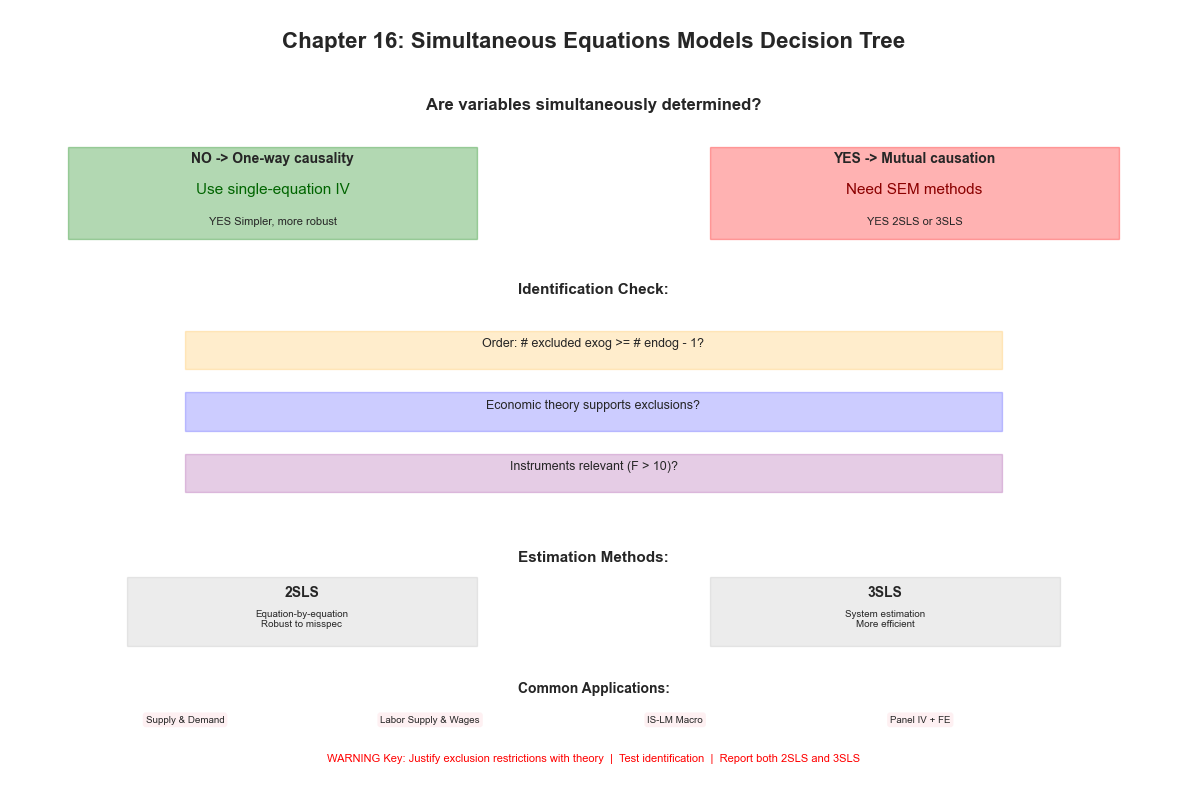

In [14]:
# Visual summary
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis("off")

# Title
ax.text(
    0.5,
    0.95,
    "Chapter 16: Simultaneous Equations Models Decision Tree",
    ha="center",
    fontsize=16,
    fontweight="bold",
)

# Question 1: Simultaneity?
ax.text(
    0.5,
    0.87,
    "Are variables simultaneously determined?",
    ha="center",
    fontsize=12,
    fontweight="bold",
)

# Branch: No
ax.add_patch(
    plt.Rectangle((0.05, 0.70), 0.35, 0.12, fill=True, alpha=0.3, color="green")
)
ax.text(
    0.225, 0.80, "NO -> One-way causality", ha="center", fontsize=10, fontweight="bold"
)
ax.text(
    0.225, 0.76, "Use single-equation IV", ha="center", fontsize=11, color="darkgreen"
)
ax.text(0.225, 0.72, "YES Simpler, more robust", ha="center", fontsize=8)

# Branch: Yes
ax.add_patch(plt.Rectangle((0.6, 0.70), 0.35, 0.12, fill=True, alpha=0.3, color="red"))
ax.text(
    0.775, 0.80, "YES -> Mutual causation", ha="center", fontsize=10, fontweight="bold"
)
ax.text(0.775, 0.76, "Need SEM methods", ha="center", fontsize=11, color="darkred")
ax.text(0.775, 0.72, "YES 2SLS or 3SLS", ha="center", fontsize=8)

# Identification
ax.text(0.5, 0.63, "Identification Check:", ha="center", fontsize=11, fontweight="bold")

checks = [
    "Order: # excluded exog >= # endog - 1?",
    "Economic theory supports exclusions?",
    "Instruments relevant (F > 10)?",
]
colors_check = ["orange", "blue", "purple"]
for i, (check, color) in enumerate(zip(checks, colors_check, strict=False)):
    y_pos = 0.56 - i * 0.08
    ax.add_patch(
        plt.Rectangle(
            (0.15, y_pos - 0.03), 0.7, 0.05, fill=True, alpha=0.2, color=color
        )
    )
    ax.text(0.5, y_pos, check, ha="center", fontsize=9)

# Estimation methods
ax.text(0.5, 0.28, "Estimation Methods:", ha="center", fontsize=11, fontweight="bold")

methods = [
    ("2SLS", "Equation-by-equation\nRobust to misspec"),
    ("3SLS", "System estimation\nMore efficient"),
]

for i, (method, desc) in enumerate(methods):
    x_pos = 0.25 if i == 0 else 0.75
    ax.add_patch(
        plt.Rectangle(
            (x_pos - 0.15, 0.17), 0.3, 0.09, fill=True, alpha=0.15, color="gray"
        )
    )
    ax.text(x_pos, 0.235, method, ha="center", fontsize=10, fontweight="bold")
    ax.text(x_pos, 0.195, desc, ha="center", fontsize=7)

# Applications
ax.text(0.5, 0.11, "Common Applications:", ha="center", fontsize=10, fontweight="bold")

apps = ["Supply & Demand", "Labor Supply & Wages", "IS-LM Macro", "Panel IV + FE"]
for i, app in enumerate(apps):
    x_pos = 0.15 + i * 0.21
    ax.text(
        x_pos,
        0.07,
        app,
        ha="center",
        fontsize=7,
        bbox=dict(boxstyle="round", alpha=0.1),
    )

# Bottom warnings
ax.text(
    0.5,
    0.02,
    "WARNING Key: Justify exclusion restrictions with theory  |  Test identification  |  Report both 2SLS and 3SLS",
    ha="center",
    fontsize=8,
    color="red",
)

plt.tight_layout()
plt.show()